# Comparative Analysis

**Goals:** 
1. Find receptors that are highly expressed in NMU+ neurons (dot plot).
2. Cluster on the graph genes that fit:

Genes that are expressed in NMUen on a X proportion of cells. For each receptor gene, calculate the proportion of cells in your neuronal subset that express the gene above a certain threshold (e.g., >0 counts or log-normalized expression value >0). Set a threshold for minimum expression level (like a minimum number of counts) and minimum percentage of cells expressing the gene to consider it as "expressed." For example, a receptor gene could be considered "expressed" if more than 60% of cells show non-zero expression.



## Imports 

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
import scanpy as sc
import warnings

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
%pip install cellphonedb

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.3/342.3 kB 5.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 2.8 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11372 sha256=69665faf87603e292aeaf10362fbd974b8440838e859d10df3fa0dad1d841bf3
  Stored in directory: /home/bnguyen3/.cache/pip/wheels/04/15/cd/2f622795b09e83471a3be5d2581cd9cf96a6ec7aa78e8deffe
Successfully built fbpca
Note: you may need to restart the kernel to use updated packages.


## Set-Up and Functions

In [4]:
# Some plotting settings from Setty Lab
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

In [5]:
def read_matrix_files(file_base, samples):
    """
    Takes a file base (string) and a list of samples
    Returns a dictionary with the sample name as the key and the corresponding Anndata object as value
    """
    sample_dict = dict()
    for sample in samples: 
        ad = sc.read(file_base + sample + matrix_suffix)
        
        # Scanpy expects cells x genes, GEO stores genes x cells
        ad = ad.transpose()
        
        # read in barcode and gene files, they are stored as tsvs
        barcodes = pd.read_csv(file_base + sample + barcode_suffix, header=None, sep='\t')
        genes = pd.read_csv(file_base + sample + gene_suffix, header=None, sep='\t')

        # Annotate data
        ad.obs_names = sample + '#' + ad.obs_names

        barcodes.rename(columns={0:'barcode'}, inplace=True)
        barcodes.set_index('barcode', inplace=True)
        ad.obs = barcodes
        
        if len(genes.columns) == 3:
            genes.rename(columns={0:'gene_ids', 1:'gene', 2: 'feature_types'}, inplace=True)
        if len(genes.columns) == 2:
            genes.rename(columns={0:'gene_ids', 1:'gene'}, inplace=True)
        else:
            genes.rename(columns={0:'gene'}, inplace=True)
        genes.set_index('gene', inplace=True)
        ad.var = genes

        # Add sample info to dictionary
        sample_dict[sample] = ad
        sample_dict[sample].var_names_make_unique()
        
        # Set the .obs['sample'] to the sample name
        sample_dict[sample].obs['sample'] = sample
        
    return sample_dict

In [6]:
def basic_metrics(samples, sample_dict):
    """
    Takes list of samples and dictionary of samples generated from the read_matrix_files function
    Returns a dictionary of barcodes from the samples with computed quality metrics
    """
    sample_cells = dict()
    for sample in samples:
        sample_cells[sample] = sample_dict[sample].obs_names
        ad = sample_dict[sample]
        ad.var['mt'] = ad.var_names.str.startswith('mt-')
        sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], inplace=True, percent_top=None, log1p=False)
    return sample_cells

In [7]:
def graph_qc(ad, THRESHOLDS=np.zeros(2)):
    """
    Take an Anndata object
    Display 3 QC graphs: molecules per cell, genes per cell, mitochondrial genes per cell
    """
    plt.figure()
    if all(i == 0 for i in THRESHOLDS):
        THRESHOLDS = np.log10(np.percentile((ad.obs['total_counts']), [3, 98]))
    figs, axs = plt.subplots(1, 3, figsize=(10, 3))
    axs[0].hist(np.log10(ad.obs['total_counts']), 50)
    axs[0].set_xlabel('log10(nUMI/cell)')
    axs[0].set_ylabel('Frequency')
    
    axs[1].hist(ad.obs['n_genes_by_counts'], 50)
    axs[1].set_xlabel('nGenes/cell')
    axs[1].set_ylabel('Frequency')

    axs[2].hist(ad.obs['pct_counts_mt'], 50)
    axs[2].set_xlabel('% Mitochondrial genes /cell')
    axs[2].set_ylabel('Frequency')
    sns.despine()

In [8]:
def merge(samples, sample_dict, sample_cells):
    """
    Returns merged Anndata object of all the samples
    """
    sample = samples[0]
    ad = sample_dict[sample][sample_cells[sample]]
    for sample in samples[1:]:
        ad = ad.concatenate(sample_dict[sample][sample_cells[sample]], 
                                index_unique=None, batch_key='batch')
    ad.obs_names_make_unique()
    # Clean up var object
    ad.var = pd.DataFrame(index=ad.var_names)
    return ad

In [9]:
def cluster(ad, algorithm, num_neighbors, pcs, res, num_top_genes):
    """
    Selects the top n most variable genes, performs PCA on these genes, keeps n PCs, calculates kNN graph on n neighbors (default), and performs Leiden algorithm (res = 1.0 default)
    Returns updated AnnData object

    ad: AnnDataObject
    algorithm: str
    num_neighbors: int 
    pcs: int
    res: int
    num_top_genes: int
    """
    # calculate highly variable genes, keep top 1500
    sc.pp.highly_variable_genes(ad, flavor='cell_ranger', n_top_genes=num_top_genes)
    
    # PCA using HVG
    sc.pp.pca(ad, use_highly_variable=True, n_comps=pcs)
    sc.pp.neighbors(ad, n_neighbors=num_neighbors, use_rep='X_pca')
    
    if algorithm == 'phenograph':
        # Phenograph
        ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_pca'])
        ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)
        
    if algorithm == 'leiden':
        key = 'leiden_' + str(res)
        sc.tl.leiden(ad, resolution=res, key_added=key)
        
    return ad

## Load Data

In [12]:
# Set up file name definitions
sample_myenteric = ['P21_1', 'P21_2']
file_base = '../Raw Data/'
matrix_suffix = '_matrix.mtx'
barcode_suffix = '_barcodes.tsv'
gene_suffix = '_genes.tsv'

In [13]:
# 10X myenteric plexus of small intestine
myenteric_dict = read_matrix_files(file_base, sample_myenteric)
myenteric_cells = basic_metrics(sample_myenteric, myenteric_dict)

## Visualize QC Info

<Figure size 400x400 with 0 Axes>

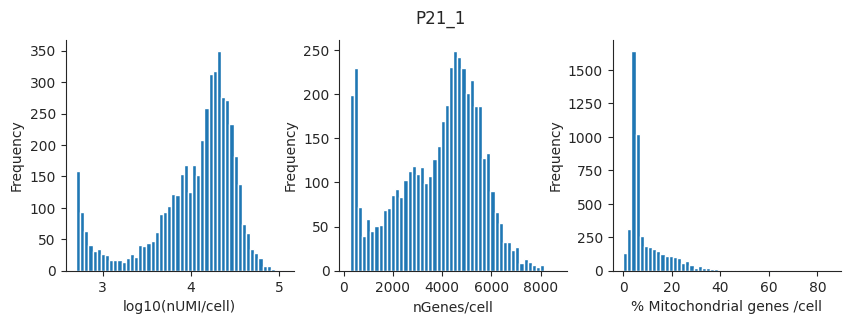

<Figure size 400x400 with 0 Axes>

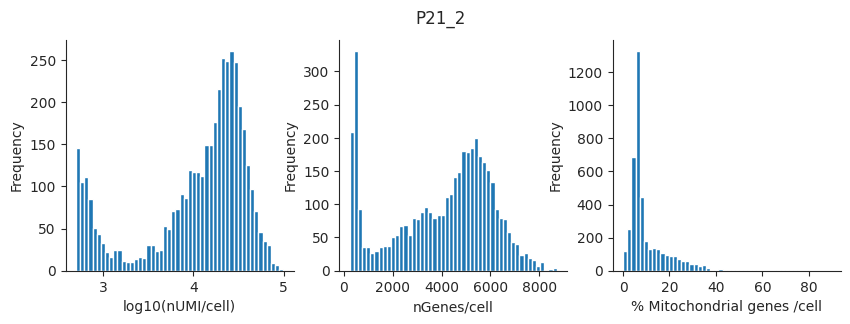

In [14]:
for sample in sample_myenteric:
    ad = myenteric_dict[sample]
    graph_qc(ad)
    plt.suptitle(sample)

## Filter 

In [15]:
# Myenteric plexus
# merge P21 replicates
myenteric_ad = merge(sample_myenteric, myenteric_dict, myenteric_cells)

/loc/scratch/60901453/ipykernel_31847/3024589798.py:8: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  ad = ad.concatenate(sample_dict[sample][sample_cells[sample]],
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch
barcode,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0
...,...,...,...,...,...,...
TTTGTTGCAGGTGGAT-1,P21_2,3360,8858.0,1827.0,20.625423,1
TTTGTTGTCAGCACCG-1,P21_2,3096,8355.0,1395.0,16.696589,1
TTTGTTGTCAGGCGAA-1,P21_2,7274,59485.0,3658.0,6.149449,1


In [17]:
sc.pp.filter_genes(myenteric_ad, min_cells=5)

# remove cells with <1500 or > 8000 genes
sc.pp.filter_cells(myenteric_ad, min_genes=1500)
sc.pp.filter_cells(myenteric_ad, max_genes=8000)

# remove cells with >60000 UMI counts to remove potential doublets
myenteric_ad = myenteric_ad[myenteric_ad.obs['total_counts'] < 60000, :]

# remove cells with mt% > 25 for cells with >4000 genes, mt% > 10% for cells with <4000 genes
myenteric_ad = myenteric_ad[~((myenteric_ad.obs.pct_counts_mt > 25) & (myenteric_ad.obs.n_genes > 4000)), :]
myenteric_ad = myenteric_ad[~((myenteric_ad.obs.pct_counts_mt > 10) & (myenteric_ad.obs.n_genes < 4000)), :]

<Figure size 400x400 with 0 Axes>

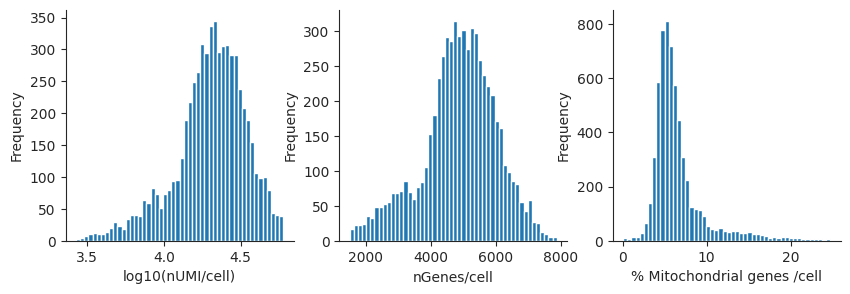

In [18]:
graph_qc(myenteric_ad)

In [19]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes
barcode,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888
...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224


In [20]:
myenteric_ad.var

,n_cells
gene,
Xkr4,1828
Gm1992,50
Mrpl15,5243
Lypla1,3877
Gm37988,37
...,...
AC132444.6,9
AC168977.1,24
PISD,6013


## Analysis

In [21]:
# Normalize and log transform
sc.pp.normalize_per_cell(myenteric_ad) # Note that the authors normalized using a different method

#log_transform(myenteric_ad)
sc.pp.log1p(myenteric_ad)

# Remove sex-specific and immediate early genes
sex_genes = ['Xist', 'Gm13305', 'Tsix', 'Eif253y', 'Ddx3y', 'Uty']
early = ['Fos', 'Jun', 'Junb', 'Egr1']

sex_genes_mk = np.in1d(myenteric_ad.var_names.values.astype(str), sex_genes)
myenteric_ad = myenteric_ad[:,~sex_genes_mk]

early_mk = np.in1d(myenteric_ad.var_names.values.astype(str), early)
myenteric_ad = myenteric_ad[:,~early_mk]

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:569: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [22]:
myenteric_ad.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts
barcode,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888,8800.0
...,...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057,4495.0
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0


In [23]:
myenteric_ad.var 

,n_cells
gene,
Xkr4,1828
Gm1992,50
Mrpl15,5243
Lypla1,3877
Gm37988,37
...,...
AC132444.6,9
AC168977.1,24
PISD,6013


In [24]:
# Retain 3000 top genes
myenteric_ad = cluster(ad=myenteric_ad, algorithm='leiden', num_neighbors=10, pcs=50, res=1.5, num_top_genes=3000)
sc.tl.umap(myenteric_ad)

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:693: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/loc/scratch/60901453/ipykernel_31847/4187430578.py:27: FutureWarning: In the future, the default backend f

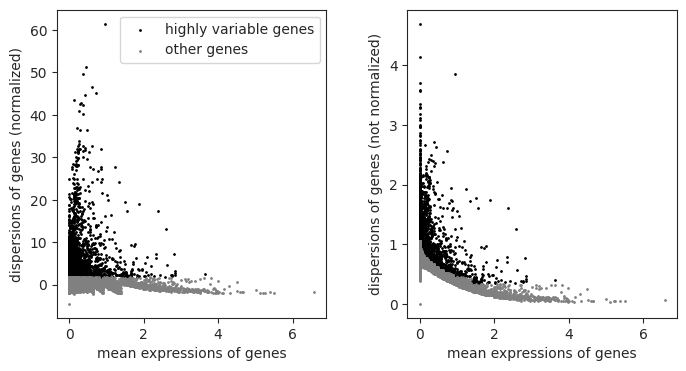

In [25]:
sc.pl.highly_variable_genes(myenteric_ad)

In [26]:
myenteric_ad.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5
barcode,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3
AAACGAAAGATGCAGC-1,P21_1,2890,8803.0,421.0,4.782461,0,2888,8800.0,5
...,...,...,...,...,...,...,...,...,...
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2
TTTGATCTCGGACAAG-1,P21_2,2057,4495.0,327.0,7.274750,1,2057,4495.0,5
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4


In [27]:
# Sanity check
is_variable = myenteric_ad.var['highly_variable'] == True
myenteric_ad.var['highly_variable'][is_variable]

gene
Gm1992     True
Oprk1      True
St18       True
Adhfe1     True
Prex2      True
           ... 
Gfra1      True
Shtn1      True
Slc18a2    True
Gm7102     True
mt-Nd6     True
Name: highly_variable, Length: 3000, dtype: bool

## Visualization

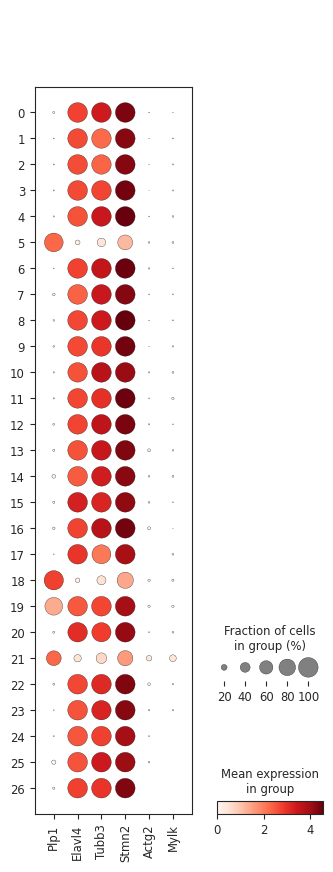

In [28]:
sc.pl.dotplot(myenteric_ad, ['Plp1', 'Elavl4', 'Tubb3', 'Stmn2', 'Actg2', 'Mylk'], 'leiden_1.5')

In [69]:
# myenteric_ad.obs.groupby('leiden_1.5')['pct_counts_mt'].describe()

In [29]:
# remove clusters with glia + neuron marker overlap
myenteric_clean = myenteric_ad[~myenteric_ad.obs['leiden_1.5'].isin(['5', '18']),:].copy()

<Figure size 400x400 with 0 Axes>

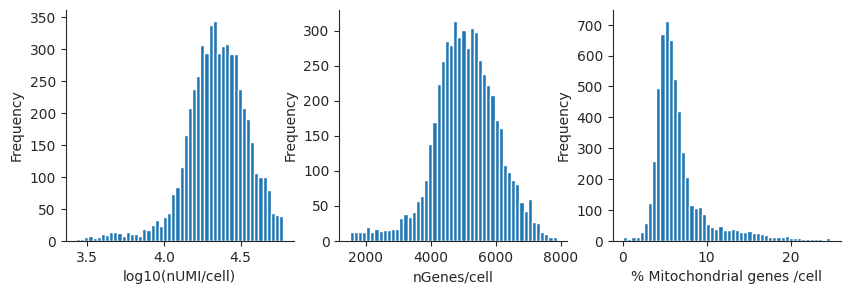

In [30]:
# Quality check
graph_qc(myenteric_clean)

In [31]:
sc.pp.highly_variable_genes(myenteric_clean, flavor='cell_ranger', n_top_genes=1500)

# PCA using HVG
sc.pp.pca(myenteric_clean, use_highly_variable=True, n_comps=35)
sc.pp.neighbors(myenteric_clean, use_rep='X_pca')
sc.tl.umap(myenteric_clean)
sc.tl.leiden(myenteric_clean) # res = 1.0

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [32]:
myenteric_clean.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden
barcode,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,6
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,8
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4
...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,19
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,3
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,0


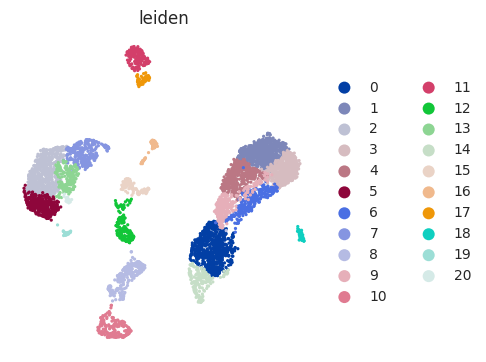

In [33]:
sc.pl.scatter(myenteric_clean, basis='umap', color=['leiden'], frameon=False)

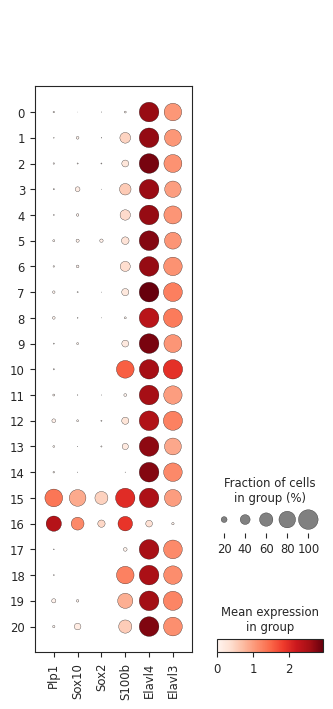

In [34]:
sc.pl.dotplot(myenteric_clean, ['Plp1', 'Sox10', 'Sox2', 'S100b', 'Elavl4', 'Elavl3'], 'leiden')

In [35]:
# remove glia
ad_mn = myenteric_clean[~myenteric_clean.obs['leiden'].isin(['15', '16']),:].copy()

In [36]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden
barcode,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,6
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,8
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4
...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,19
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,3
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,0


In [37]:
sc.pp.highly_variable_genes(ad_mn, flavor='cell_ranger', n_top_genes=1500)

# PCA using HVG
sc.pp.pca(ad_mn, use_highly_variable=True, n_comps=30)
sc.pp.neighbors(ad_mn, use_rep='X_pca')
sc.tl.umap(ad_mn)
sc.tl.leiden(ad_mn)
sc.tl.leiden(ad_mn, resolution = 0.4, key_added = "leiden_0.4")

/home/bnguyen3/.conda/envs/jupyterenv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


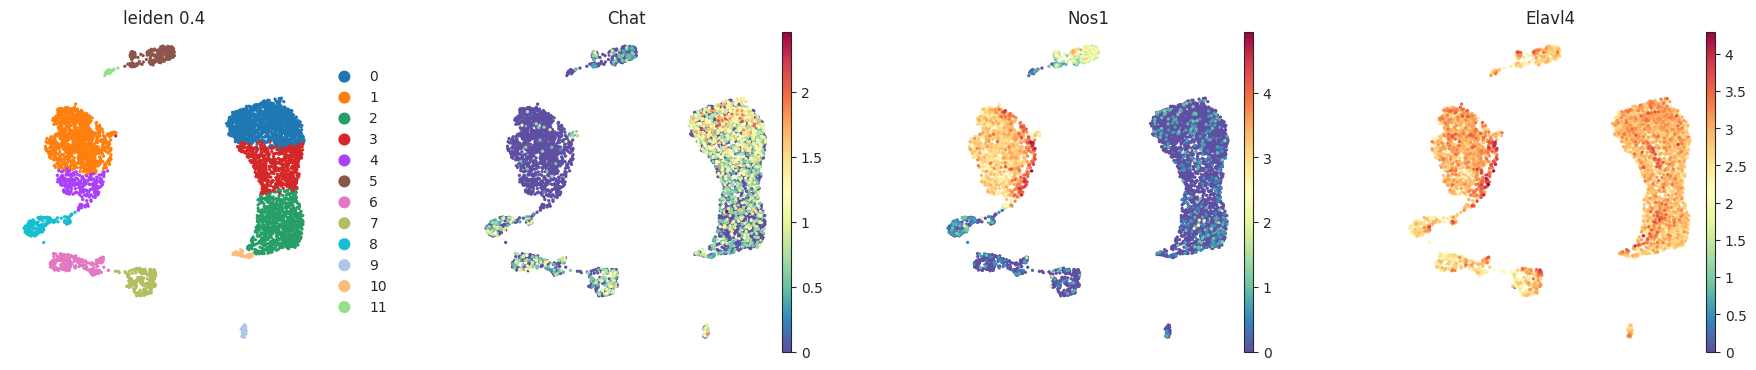

In [38]:
sc.pl.scatter(ad_mn, basis='umap', color=['leiden_0.4', 'Chat', 'Nos1', 'Elavl4'], frameon=False)

## Celltype Identification

Marker Dictionaries

In [39]:
si_features_dict = {'Distinguishing': ['Tac1', 'Calb2', 'Ndufa4l2', 'Gda', 'Penk', 'Fut9', 'Nfatc1', 'Sst',
                                 'Nmu', 'Nog', 'Cck', 'Ucn3', 'C1ql1', 'Cox8b', 'Npy', 'Rprml', 'Neurod6',
                                 'Ntng1', 'Nxph2'],
               'Cholinergic': ['Chat', 'Slc18a3'],
               'Nitrergic': ['Nos1'],
               'GABAergic': ['Gad2'],
               'Glutamatergic': ['Slc17a6'],
               'Catecholaminergic': ['Th', 'Dbh'],
               'Serotonergic': ['Ddc', 'Slc18a2'],
               'Other': ['Gal', 'Vip', 'Calcb', 'Calb1', 'Nefm']
              }

In [40]:
ad_mn.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4
barcode,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2


In [41]:
pd.Series("", index=ad_mn.obs['leiden_0.4'].values.categories)

0     
1     
2     
3     
4     
5     
6     
7     
8     
9     
10    
11    
dtype: object

In [42]:
cell_types = pd.Series("", index=ad_mn.obs['leiden_0.4'].values.categories)
cell_types['0'] = 'ENC1'
cell_types['1'] = 'ENC8'
cell_types['2'] = 'ENC3'
cell_types['3'] = 'ENC2'
cell_types['4'] = 'ENC9'
cell_types['5'] = 'ENC7'
cell_types['6'] = 'ENC10'
cell_types['7'] = 'ENC6'
cell_types['8'] = 'ENC12'
cell_types['9'] = 'ENC5'
cell_types['10'] = 'ENC4'
cell_types['11'] = 'ENC11'

In [43]:
cell_types

0      ENC1
1      ENC8
2      ENC3
3      ENC2
4      ENC9
5      ENC7
6     ENC10
7      ENC6
8     ENC12
9      ENC5
10     ENC4
11    ENC11
dtype: object

In [44]:
ad_mn.obs['celltype'] = cell_types[ad_mn.obs['leiden_0.4']].values

In [45]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2,ENC3


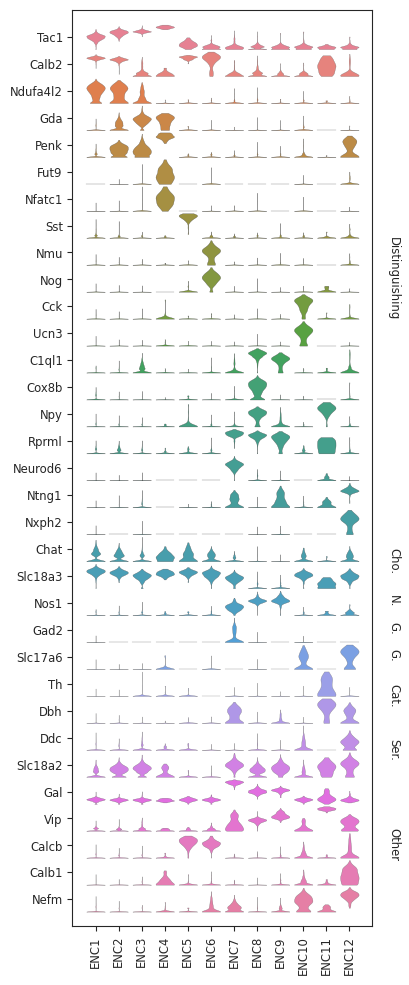

In [46]:
sc.pl.stacked_violin(ad_mn, si_features_dict, row_palette='husl', groupby='celltype', swap_axes=True)

ENC1 = Calb2, Ndufa4l2 \
ENC2 = Calb2, Gda/Penk, Ndufa4l2 \
ENC3 = Calb2-, Gda/Penk, Ndufa4l2 \
ENC4 = Fut9, Gda/Penk, Calb2- \
ENC8 = Nos1, Npy, Rprml \
ENC9 = Nos1, Npy-, Rprml \
ENC10 = Gad2, Neurod6, Rprml \
ENC5 = Sst, Calb2, Calcb \
ENC6 = Nmu, Calb2, Calcb \
ENC7 = Ucn3, Cck, vGlut2 \
ENC12 = Nxph2, Ntng1, Calb1, vGlut2 \
ENC11 = Npy, Th, Dbh, Calb2

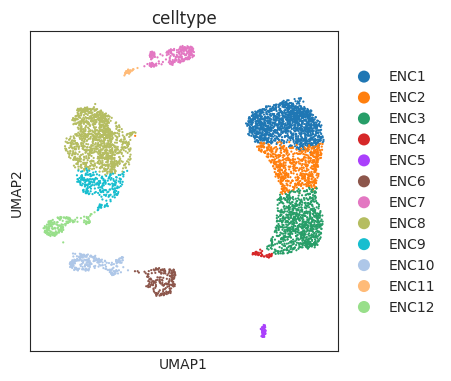

In [47]:
sc.pl.scatter(ad_mn, basis='umap', size=10, color='celltype')

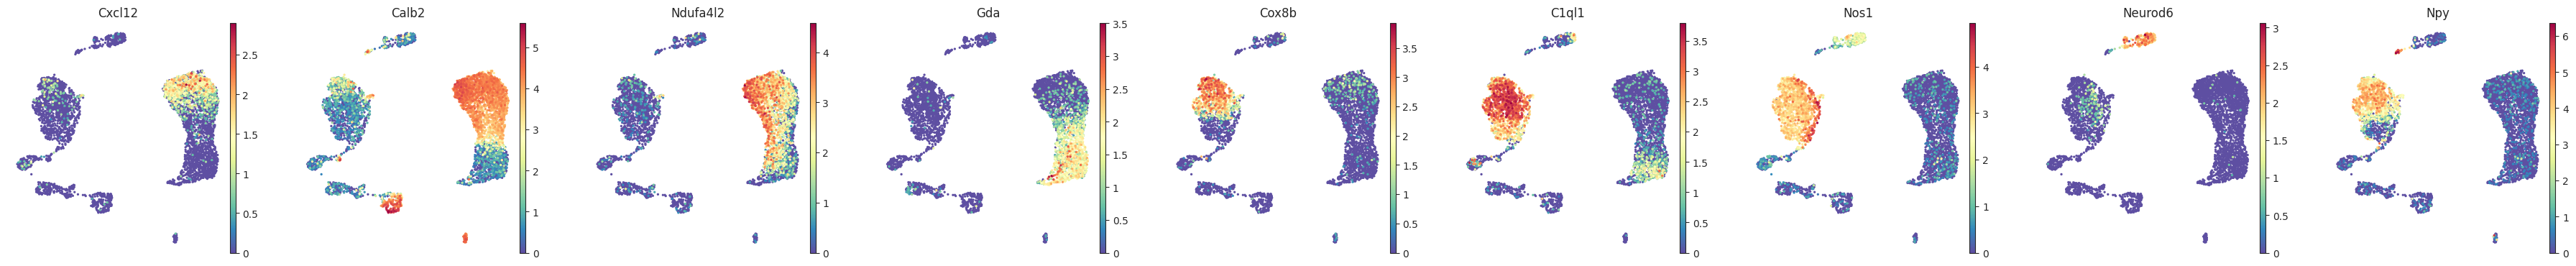

In [48]:
sc.pl.scatter(ad_mn, basis='umap', color=['Cxcl12', 'Calb2', 'Ndufa4l2', 'Gda', 
                                          'Cox8b', 'C1ql1', 'Nos1', 'Neurod6', 'Npy'], frameon=False)

In [107]:
# Save AnnData Object
ad_mn.write('ad_mn.h5ad')

## Find Receptors

In [10]:
%pwd

'/fh/fast/talbot_j/grp/TalbotLab/Current_Lab_Members/Brandon_Nguyen/Project/Results/BN002/Scripts'

In [82]:
ad_mn = sc.read('../ad_mn.h5ad')

In [83]:
ad_mn.obs 

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2,ENC3


In [85]:
matplotlib.rcdefaults()

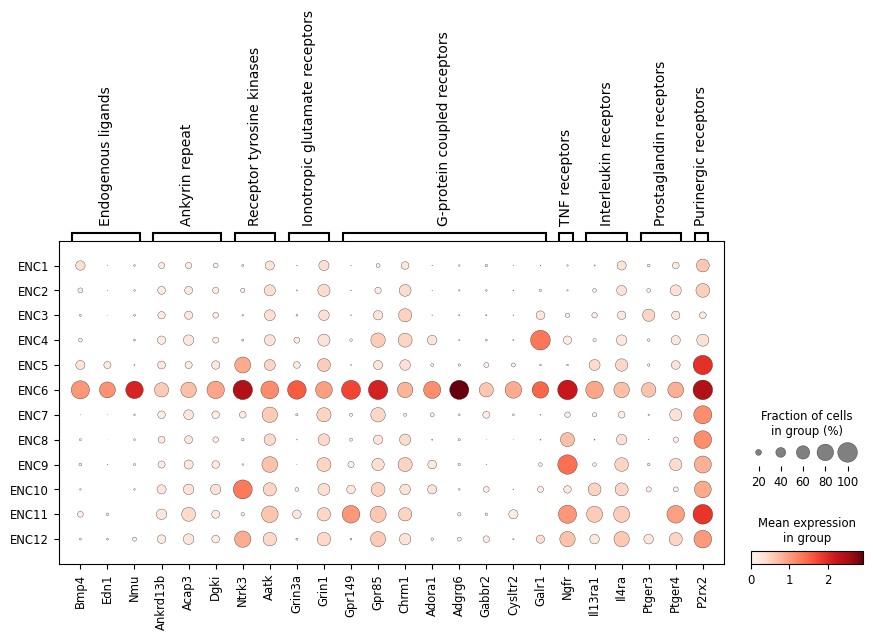

In [86]:
# Example:
# markers = {'T-cell': 'CD3D', 'B-cell': 'CD79A', 'myeloid': 'CST3'}
# sc.pl.dotplot(adata, markers, groupby='bulk_labels', dendrogram=True)

markers = {'Endogenous ligands': ['Bmp4', 'Edn1', 'Nmu'],
          'Ankyrin repeat': ['Ankrd13b', 'Acap3', 'Dgki'],
          'Receptor tyrosine kinases': ['Ntrk3', 'Aatk'],
          'Ionotropic glutamate receptors': ['Grin3a', 'Grin1'],
          'G-protein coupled receptors': ['Gpr149', 'Gpr85', 'Chrm1','Adora1', 'Adgrg6', 'Gabbr2', 'Cysltr2', 'Galr1'],
          'TNF receptors': ["Ngfr"],
          'Interleukin receptors': ['Il13ra1', 'Il4ra'],
          'Prostaglandin receptors': ['Ptger3', 'Ptger4'],
          'Purinergic receptors': ['P2rx2']}

sc.pl.dotplot(ad_mn, markers, groupby='celltype')

### Check HGNC Families

In [33]:
# endogenous_ligands = [
#     'Adcyap1', 'Adipoq', 'Adm', 'Adm2', 'Agrp', 'Agt', 'Amh', 'Anxa1', 'Apln', 
#     'App', 'Areg', 'Arf1', 'Arhgdib', 'Artn', 'Avp', 'Bdnf', 'Bid', 'Bmp10', 
#     'Bmp2', 'Bmp4', 'Bmp5', 'Bmp6', 'Bmp7', 'Bmp8a', 'C3', 'Calca', 'Camp', 
#     'Cck', 'Ccl1', 'Ccl11', 'Ccl12', 'Ccl17', 'Ccl19', 'Ccl2', 'Ccl20', 'Ccl22', 
#     'Ccl24', 'Ccl25', 'Ccl28', 'Ccl4', 'Ccl5', 'Cd274', 'Cd40lg', 'Cflar', 'Cga', 
#     'Cntn1', 'Copa', 'Cort', 'Crh', 'Csf3', 'Ctsg', 'Cx3cl1', 'Cxcl1', 'Cxcl10', 
#     'Cxcl12', 'Cxcl13', 'Cxcl16', 'Cxcl2', 'Cxcl5', 'Edn1', 'Edn2', 'Edn3', 'F2', 
#     'Fasl', 'Fga', 'Fgb', 'Fgf1', 'Fgf2', 'Fgf4', 'Fgf5', 'Fgf6', 'Fgf7', 'Fgf8', 
#     'Fgf9', 'Fgg', 'Fn1', 'Fshb', 'Gal', 'Gast', 'Gdf10', 'Gdf2', 'Gdf3', 'Gdf9', 
#     'Gdnf', 'Ghrh', 'Ghrl', 'Gip', 'Grp', 'Guca2a', 'Guca2b', 'Hc', 'Hcrt', 
#     'Hebp1', 'Htt', 'Iapp', 'Icam1', 'Icam2', 'Icosl', 'Igf1', 'Il11', 'Il1a', 
#     'Il1b', 'Il1rn', 'Inhba', 'Inhbb', 'Ins2', 'Insl5', 'Kng1', 'Lgals1', 'Lgals3', 
#     'Lgals3bp', 'Lhb', 'Lrrc4b', 'Mmp13', 'Mmp1a', 'Ncan', 'Ndp', 'Ngf', 'Nmu', 
#     'Npb', 'Npff', 'Nppa', 'Nppc', 'Npvf', 'Npy', 'Nrtn', 'Ntf3', 'Ntf5', 'Nts', 
#     'Oxt', 'Pdcd1lg2', 'Pdyn', 'Penk', 'Pmch', 'Pnoc', 'Pomc', 'Ppy', 'Proc', 
#     'Prok2', 'Psap', 'Pspn', 'Pth', 'Pth2', 'Pthlh', 'Ptn', 'Pyy', 'Rac1', 'Rac2', 
#     'Rac3', 'Rarres2', 'Rb1', 'Rgs2', 'Rln1', 'Rspo1', 'Rspo2', 'Rspo3', 'Rspo4', 
#     'Saa1', 'Selplg', 'Spp1', 'Sst', 'Tac1', 'Tac2', 'Tgfb1', 'Tgfb2', 'Tgfb3', 
#     'Thpo', 'Trh', 'Tshb', 'Ucn', 'Ucn2', 'Ucn3', 'Uts2', 'Vcam1', 'Vip', 'Vtn', 
#     'Vwf', 'Wnt1', 'Wnt2', 'Wnt3', 'Wnt3a', 'Wnt4', 'Wnt5a', 'Wnt7b', 'Xcl1'
# ]

endogenous_ligands = ['Bmp4', 'Edn1', 'Nmu', 'Vwf']

endogenous_ligands = list(set(endogenous_ligands) & set(ad_mn.var.index))
endogenous_ligands

['Bmp4', 'Edn1', 'Nmu', 'Vwf']

In [34]:
# ankyrin_repeat_domain_containing = [
#     'Abtb1', 'Abtb2', 'Acap1', 'Acap2', 'Acap3', 'Acbd6', 'Agap1', 'Agap2', 'Agap3', 
#     'Ank1', 'Ank3', 'Ankdd1b', 'Ankfy1', 'Ankhd1', 'Ankib1', 'Ankle1', 'Ankle2', 
#     'Ankmy2', 'Ankra2', 'Ankrd1', 'Ankrd10', 'Ankrd11', 'Ankrd12', 'Ankrd13a', 'Ankrd13b', 
#     'Ankrd13c', 'Ankrd13d', 'Ankrd16', 'Ankrd17', 'Ankrd2', 'Ankrd22', 'Ankrd23', 
#     'Ankrd24', 'Ankrd26', 'Ankrd27', 'Ankrd28', 'Ankrd29', 'Ankrd33', 'Ankrd33b', 
#     'Ankrd34a', 'Ankrd34b', 'Ankrd35', 'Ankrd37', 'Ankrd39', 'Ankrd40', 'Ankrd42', 
#     'Ankrd44', 'Ankrd45', 'Ankrd46', 'Ankrd49', 'Ankrd52', 'Ankrd54', 'Ankrd55', 
#     'Ankrd6', 'Ankrd61', 'Ankrd7', 'Ankrd9', 'Anks1', 'Anks1b', 'Anks3', 'Anks4b', 
#     'Ankzf1', 'Arap1', 'Arap2', 'Arap3', 'Asap1', 'Asap2', 'Asap3', 'Asb1', 'Asb10', 
#     'Asb11', 'Asb12', 'Asb13', 'Asb14', 'Asb15', 'Asb16', 'Asb17', 'Asb18', 'Asb2', 
#     'Asb3', 'Asb4', 'Asb5', 'Asb6', 'Asb7', 'Asb8', 'Asb9', 'Aspg', 'Asz1', 'Bank1', 
#     'Bard1', 'Bcl3', 'Bcor', 'Bcorl1', 'Btbd11', 'Caskin1', 'Caskin2', 'Cdkn2c', 
#     'Clip3', 'Clip4', 'Clpb', 'Cttnbp2', 'Dapk1', 'Dgki', 'Ehmt1', 'Ehmt2', 'Espn', 
#     'Fank1', 'Fem1a', 'Fem1b', 'Fem1c', 'Gabpb1', 'Gabpb2', 'Git1', 'Git2', 'Gls', 
#     'Gls2', 'Hace1', 'Hectd1', 'Ibtk', 'Ilk', 'Invs', 'Kank1', 'Kank2', 'Kank3', 
#     'Kank4', 'Kidins220', 'Krit1', 'Mib1', 'Mib2', 'Mphosph8', 'Mtpn', 'Myo16', 
#     'Nfkb1', 'Nfkb2', 'Nfkbia', 'Nfkbib', 'Nfkbid', 'Nfkbie', 'Nfkbiz', 'Notch1', 
#     'Notch2', 'Notch3', 'Notch4', 'Nrarp', 'Nudt12', 'Osbpl1a', 'Ostf1', 'Pla2g6', 
#     'Ppp1r12a', 'Ppp1r12c', 'Ppp1r13b', 'Ppp1r13l', 'Ppp1r16a', 'Ppp1r16b', 'Psmd10', 
#     'Rai14', 'Rfxank', 'Ripk4', 'Rnasel', 'Shank1', 'Shank2', 'Shank3', 'Sncaip', 
#     'Tanc1', 'Tanc2', 'Tnks', 'Tnks2', 'Trank1', 'Trp53bp2', 'Trpa1', 'Trpc4', 
#     'Trpv1', 'Trpv2', 'Trpv4', 'Trpv6', 'Uaca', 'Zdhhc13', 'Zdhhc17'
# ]

ankyrin_repeat_domain_containing = ['Ankrd13b', 'Acap3', 'Dgki', 'Bcor']

ankyrin_repeat_domain_containing = list(set(ankyrin_repeat_domain_containing) & set(ad_mn.var.index))
ankyrin_repeat_domain_containing

['Dgki', 'Bcor', 'Acap3', 'Ankrd13b']

In [37]:
# receptor_tyrosine_kinases = [
#     'Aatk', 'Alk', 'Axl', 'Csf1r', 'Ddr1', 'Ddr2', 'Fgfr1', 'Fgfr2', 'Fgfr3', 
#     'Fgfr4', 'Flt1', 'Flt3', 'Flt4', 'Igf1r', 'Insr', 'Insrr', 'Kdr', 'Kit', 
#     'Lmtk2', 'Lmtk3', 'Ltk', 'Mertk', 'Met', 'Mst1r', 'Musk', 'Ntrk1', 'Ntrk2', 
#     'Ntrk3', 'Pdgfra', 'Pdgfrb', 'Ptk7', 'Ret', 'Ror1', 'Ror2', 'Ros1', 'Ryk', 
#     'Styk1', 'Tek', 'Tie1', 'Tyro3'
# ]

receptor_tyrosine_kinases = ['Ntrk3', 'Aatk']

receptor_tyrosine_kinases = list(set(receptor_tyrosine_kinases) & set(ad_mn.var.index))
receptor_tyrosine_kinases

['Aatk', 'Ntrk3']

In [38]:
# ionotropic_glutamate_receptors = [
#     'Gria1', 'Gria2', 'Gria3', 'Gria4', 'Grid1', 'Grid2', 'Grik1', 'Grik2', 'Grik3', 
#     'Grik4', 'Grik5', 'Grin1', 'Grin2a', 'Grin2b', 'Grin2c', 'Grin2d', 'Grin3a', 
#     'Grin3b'
# ]

ionotropic_glutamate_receptors = ['Grin3a', 'Grin1']

ionotropic_glutamate_receptors = list(set(ionotropic_glutamate_receptors) & set(ad_mn.var.index))
ionotropic_glutamate_receptors

['Grin1', 'Grin3a']

In [40]:
# G_protein_coupled_receptors_Class_A_orphans = [
#     'Gpr1', 'Gpr101', 'Gpr12', 'Gpr132', 'Gpr135', 'Gpr146', 'Gpr149', 'Gpr15', 
#     'Gpr150', 'Gpr151', 'Gpr152', 'Gpr153', 'Gpr160', 'Gpr161', 'Gpr162', 'Gpr17', 
#     'Gpr171', 'Gpr173', 'Gpr174', 'Gpr176', 'Gpr18', 'Gpr182', 'Gpr183', 'Gpr19', 
#     'Gpr20', 'Gpr22', 'Gpr25', 'Gpr26', 'Gpr27', 'Gpr3', 'Gpr33', 'Gpr34', 'Gpr35', 
#     'Gpr37', 'Gpr37l1', 'Gpr39', 'Gpr4', 'Gpr45', 'Gpr50', 'Gpr6', 'Gpr61', 'Gpr62', 
#     'Gpr63', 'Gpr65', 'Gpr68', 'Gpr75', 'Gpr83', 'Gpr84', 'Gpr85', 'Gpr87', 'Gpr88', 
#     'Lgr4', 'Lgr5', 'Lgr6', 'Mas1', 'Mrgpra1', 'Mrgprb1', 'Mrgpre', 'Mrgprf', 'Mrgprg'
# ]

G_protein_coupled_receptors_Class_A_orphans = ['Gpr149', 'Gpr85']

G_protein_coupled_receptors_Class_A_orphans = list(set(G_protein_coupled_receptors_Class_A_orphans) & set(ad_mn.var.index))
G_protein_coupled_receptors_Class_A_orphans

gpcr_genes = G_protein_coupled_receptors_Class_A_orphans + ['Chrm1', 'Adora1', 'Adgrg6', 'Gabbr2', 'Cysltr2', 'Galr1']
gpcr_genes

['Gpr149', 'Gpr85', 'Chrm1', 'Adora1', 'Adgrg6', 'Gabbr2', 'Cysltr2', 'Galr1']

In [42]:
tnfr_genes = ["Ngfr"]

tnfr_genes = list(set(tnfr_genes) & set(ad_mn.var.index))
tnfr_genes

['Ngfr']

In [44]:
interleukin_receptors = ["Il13ra1"]

interleukin_receptors = list(set(interleukin_receptors) & set(ad_mn.var.index)) + ['Il4ra']
interleukin_receptors

['Il13ra1', 'Il4ra']

In [195]:
# sc.pl.dotplot(ad_mn, endogenous_ligands, 'celltype', title='Endogenous Ligands')

In [232]:
# Kv_channels = [
#     'Kcna1', 'Kcna2', 'Kcna3', 'Kcna4', 'Kcna5', 'Kcna6', 'Kcna7', 'Kcnb1', 
#     'Kcnc1', 'Kcnc2', 'Kcnc3', 'Kcnc4', 'Kcnd1', 'Kcnd2', 'Kcnd3', 'Kcnf1', 
#     'Kcng1', 'Kcng2', 'Kcng4', 'Kcnh1', 'Kcnh2', 'Kcnh3', 'Kcnh5', 'Kcnh7', 
#     'Kcnh8', 'Kcnq1', 'Kcnq2', 'Kcnq3', 'Kcnq4', 'Kcnq5', 'Kcns1', 'Kcns2', 
#     'Kcns3', 'Kcnv1', 'Kcnv2'
# ]

In [196]:
# Kv_channels = list(set(Kv_channels) & set(ad_mn.var.index))
# Kv_channels

In [197]:
# sc.pl.dotplot(ad_mn, Kv_channels, 'celltype', title='Voltage-Gated Potassium Channels')

In [199]:
# SAM_domain_containing = [
#     'Anks1', 'Anks1b', 'Anks3', 'Anks4b', 'Arap1', 'Arap2', 'Arap3', 'Asz1', 'Bfar', 'Bicc1', 
#     'Caskin1', 'Caskin2', 'Cnksr1', 'Cnksr2', 'Cnksr3', 'Ddhd2', 'Dgkd', 'Dgkh', 'Epha1', 'Epha10', 
#     'Epha2', 'Epha3', 'Epha4', 'Epha5', 'Epha6', 'Epha7', 'Epha8', 'Ephb1', 'Ephb2', 'Ephb3', 
#     'Ephb4', 'Ephb6', 'Inppl1', 'Kif24', 'L3mbtl3', 'Lrsam1', 'Phc1', 'Phc2', 'Phc3', 'Ppfia1', 
#     'Ppfia2', 'Ppfia3', 'Ppfibp1', 'Ppfibp2', 'Ppp1r9a', 'Samd1', 'Samd10', 'Samd12', 'Samd4', 
#     'Samd4b', 'Samd5', 'Samd7', 'Samd8', 'Samd9l', 'Samhd1', 'Samsn1', 'Sarm1', 'Sash1', 'Sash3', 
#     'Scmh1', 'Scml4', 'Sec23ip', 'Sfmbt1', 'Sfmbt2', 'Sgms1', 'Shank1', 'Shank2', 'Shank3', 'Stim1', 
#     'Stim2', 'Tnks', 'Tnks2', 'Wdsub1', 'Zcchc14'
# ]

# SAM_domain_containing = list(set(SAM_domain_containing) & set(ad_mn.var.index))
# SAM_domain_containing

In [200]:
# sc.pl.dotplot(ad_mn, SAM_domain_containing, 'celltype', title='Sterile Alpha Motif (SAM) Domain-Containing')

In [202]:
# sc.pl.dotplot(ad_mn, ankyrin_repeat_domain_containing, 'celltype', title='Ankyrin Repeat Domain-Containing')

In [206]:
# sc.pl.dotplot(ad_mn, receptor_tyrosine_kinases, 'celltype', title='Receptor Tyrosine Kinases')

In [207]:
# protein_tyrosine_phosphatases_receptor_type = [
#     'Ptpra', 'Ptprb', 'Ptprc', 'Ptpre', 'Ptprf', 'Ptprg', 'Ptprj', 'Ptprk', 'Ptprm', 
#     'Ptprn', 'Ptprn2', 'Ptpro', 'Ptprr', 'Ptprs', 'Ptprt', 'Ptpru', 'Ptprz1'
# ]

# protein_tyrosine_phosphatases_receptor_type = list(set(protein_tyrosine_phosphatases_receptor_type) & set(ad_mn.var.index))
# protein_tyrosine_phosphatases_receptor_type

In [215]:
# sc.pl.dotplot(ad_mn, protein_tyrosine_phosphatases_receptor_type, 'celltype', title='Receptor-type Protein Tyrosine Phosphatases (RPTPs)')

In [208]:
# sc.pl.dotplot(ad_mn, ionotropic_glutamate_receptors, 'celltype', title='Ionotropic Glutamate Receptors')

In [210]:
# P_type_ATPases = [
#     'Atp10a', 'Atp10b', 'Atp11a', 'Atp11b', 'Atp11c', 'Atp12a', 'Atp13a1', 'Atp13a2', 
#     'Atp13a3', 'Atp13a4', 'Atp13a5', 'Atp1a1', 'Atp1a2', 'Atp1a3', 'Atp1a4', 'Atp1b1', 
#     'Atp1b2', 'Atp1b3', 'Atp1b4', 'Atp2a1', 'Atp2a2', 'Atp2a3', 'Atp2b1', 'Atp2b2', 
#     'Atp2b3', 'Atp2b4', 'Atp2c1', 'Atp2c2', 'Atp4a', 'Atp4b', 'Atp7a', 'Atp7b', 
#     'Atp8a1', 'Atp8a2', 'Atp8b1', 'Atp8b2', 'Atp8b3', 'Atp8b4', 'Atp9a', 'Atp9b'
# ]

# P_type_ATPases = list(set(P_type_ATPases) & set(ad_mn.var.index))
# P_type_ATPases

In [211]:
# sc.pl.dotplot(ad_mn, P_type_ATPases, 'celltype', title='P-type ATPases')

'Ptger4'
'P2xr2'
'Cysltr2'

In [216]:
# sc.pl.dotplot(ad_mn, G_protein_coupled_receptors_Class_A_orphans, 'celltype', title='G-Protein Coupled Receptors: Class A Orphans')

In [217]:
# voltage_dependent_Ca_channels = [
#     'Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1f', 'Cacna1g', 'Cacna1h', 
#     'Cacna1s', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 'Cacnb1', 'Cacnb2', 'Cacnb3', 
#     'Cacnb4', 'Cacng1', 'Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng6', 'Cacng7', 'Cacng8'
# ]

# voltage_dependent_Ca_channels = list(set(voltage_dependent_Ca_channels) & set(ad_mn.var.index))
# voltage_dependent_Ca_channels

In [218]:
# sc.pl.dotplot(ad_mn, voltage_dependent_Ca_channels, 'celltype', title='Voltage-Dependent Calcium Channels')

In [219]:
# nuclear_hormone_receptors = [
#     'Ar', 'Esr1', 'Esr2', 'Esrrb', 'Esrrg', 'Hnf4a', 'Hnf4g', 'Nr0b1', 'Nr0b2', 
#     'Nr1d1', 'Nr1d2', 'Nr1h2', 'Nr1h3', 'Nr1h4', 'Nr1i2', 'Nr1i3', 'Nr2c1', 'Nr2c2', 
#     'Nr2e1', 'Nr2e3', 'Nr2f1', 'Nr2f2', 'Nr2f6', 'Nr3c1', 'Nr3c2', 'Nr4a1', 'Nr4a2', 
#     'Nr4a3', 'Nr5a1', 'Nr5a2', 'Nr6a1', 'Pgr', 'Ppara', 'Ppard', 'Pparg', 'Rara', 
#     'Rarb', 'Rarg', 'Rora', 'Rorb', 'Rorc', 'Rxra', 'Rxrb', 'Rxrg', 'Thra', 'Thrb', 'Vdr'
# ]

# nuclear_hormone_receptors = list(set(nuclear_hormone_receptors) & set(ad_mn.var.index))
# nuclear_hormone_receptors

In [220]:
# sc.pl.dotplot(ad_mn, nuclear_hormone_receptors, 'celltype', title='Nuclear Hormone Receptors')

In [221]:
# K_channels_two_pore_domain_subfamily_K = [
#     'Kcnk1', 'Kcnk10', 'Kcnk12', 'Kcnk13', 'Kcnk15', 'Kcnk16', 'Kcnk2', 
#     'Kcnk3', 'Kcnk4', 'Kcnk5', 'Kcnk6', 'Kcnk7'
# ]

# K_channels_two_pore_domain_subfamily_K = list(set(K_channels_two_pore_domain_subfamily_K) & set(ad_mn.var.index))
# K_channels_two_pore_domain_subfamily_K

In [222]:
# sc.pl.dotplot(ad_mn, K_channels_two_pore_domain_subfamily_K, 'celltype', title='Potassium Channels: Two-Pore Domain Subfamily K')

In [223]:
# Na_V_channels = [
#     'Scn10a', 'Scn11a', 'Scn1a', 'Scn1b', 'Scn2a1', 'Scn2b', 'Scn3a', 'Scn3b', 
#     'Scn4a', 'Scn4b', 'Scn5a', 'Scn7a', 'Scn8a', 'Scn9a'
# ]

# Na_V_channels = list(set(Na_V_channels) & set(ad_mn.var.index))
# Na_V_channels

In [224]:
# sc.pl.dotplot(ad_mn, Na_V_channels, 'celltype', title='Voltage-Gated Sodium Channels')

In [225]:
# C2_tensin_type_domain_containing = [
#     'Dnajc6', 'Gak', 'Pten', 'Tns1', 'Tns3', 'Tpte'
# ]

# C2_tensin_type_domain_containing = list(set(C2_tensin_type_domain_containing) & set(ad_mn.var.index))
# C2_tensin_type_domain_containing

In [226]:
# sc.pl.dotplot(ad_mn, C2_tensin_type_domain_containing, 'celltype', title='C2 Tensin Type Domain-Containing')

### Set Threshold

In [87]:
markers

{'Endogenous ligands': ['Bmp4', 'Edn1', 'Nmu'],
 'Ankyrin repeat': ['Ankrd13b', 'Acap3', 'Dgki'],
 'Receptor tyrosine kinases': ['Ntrk3', 'Aatk'],
 'Ionotropic glutamate receptors': ['Grin3a', 'Grin1'],
 'G-protein coupled receptors': ['Gpr149',
  'Gpr85',
  'Chrm1',
  'Adora1',
  'Adgrg6',
  'Gabbr2',
  'Cysltr2',
  'Galr1'],
 'TNF receptors': ['Ngfr'],
 'Interleukin receptors': ['Il13ra1', 'Il4ra'],
 'Prostaglandin receptors': ['Ptger3', 'Ptger4'],
 'Purinergic receptors': ['P2rx2']}

In [88]:
goi = [item for sublist in markers.values() for item in sublist]
goi

['Bmp4',
 'Edn1',
 'Nmu',
 'Ankrd13b',
 'Acap3',
 'Dgki',
 'Ntrk3',
 'Aatk',
 'Grin3a',
 'Grin1',
 'Gpr149',
 'Gpr85',
 'Chrm1',
 'Adora1',
 'Adgrg6',
 'Gabbr2',
 'Cysltr2',
 'Galr1',
 'Ngfr',
 'Il13ra1',
 'Il4ra',
 'Ptger3',
 'Ptger4',
 'P2rx2']

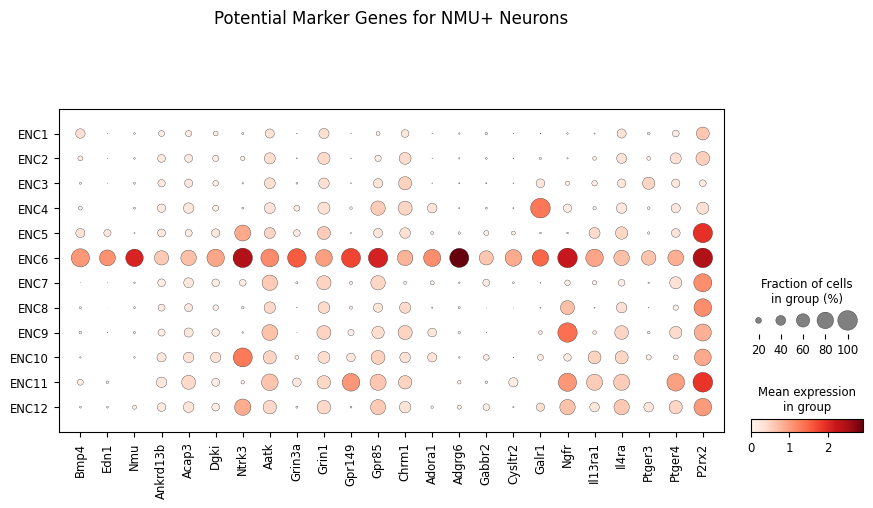

In [89]:
sc.pl.dotplot(ad_mn, goi, 'celltype', title='Potential Marker Genes for NMU+ Neurons')

Here's a brief description of each of the genes:

1. **Edn1 (Endothelin 1)**: A potent vasoconstrictor peptide involved in the regulation of vascular tone and blood pressure. It also plays roles in cell proliferation, differentiation, and development.

2. **Bmp4 (Bone Morphogenetic Protein 4)**: Part of the TGF-beta superfamily, BMP4 is crucial for embryonic development, including bone and cartilage formation, as well as tissue homeostasis and repair.

3. **Nmu (Neuromedin U)**: A neuropeptide involved in regulating energy homeostasis, feeding behavior, and pain perception. It also influences the gastrointestinal and cardiovascular systems.

4. **Vwf (Von Willebrand Factor)**: A key protein in blood clotting, involved in platelet adhesion to the site of vascular injury and in maintaining normal hemostasis. Deficiency or dysfunction of VWF leads to von Willebrand disease, a bleeding disorder.

5. **Dgki (Diacylglycerol Kinase Iota)**: Involved in lipid signaling, DGKI converts diacylglycerol (DAG) into phosphatidic acid (PA), modulating important signaling pathways related to cell proliferation and differentiation.

6. **Bcor (BCL6 Corepressor)**: A gene involved in epigenetic regulation of gene expression, particularly in development and cell differentiation. Mutations in BCOR are linked to various developmental disorders, such as oculofaciocardiodental syndrome.

7. **Ankrd13b (Ankyrin Repeat Domain 13B)**: Involved in protein-protein interactions, particularly in signaling pathways that regulate protein trafficking and cellular responses to environmental stimuli.

8. **Acap3 (ArfGAP with Coiled-Coil, Ankyrin Repeat, and PH Domain 3)**: Plays a role in endocytic trafficking and cytoskeletal organization, influencing processes like cell migration and membrane dynamics.

9. **Aatk (Apoptosis-Associated Tyrosine Kinase)**: This gene is involved in apoptotic signaling and may play a role in the regulation of cell death and neuronal differentiation.

10. **Ntrk3 (Neurotrophic Receptor Tyrosine Kinase 3)**: Encodes for a receptor for neurotrophin-3 (NT-3), involved in the development and function of the nervous system, including neuronal survival, differentiation, and synaptic plasticity.

11. **Grin1 (Glutamate Ionotropic Receptor NMDA Type Subunit 1)**: A critical component of the NMDA receptor, which is involved in synaptic plasticity and memory function. Dysregulation of GRIN1 is associated with various neurological disorders, including schizophrenia and intellectual disabilities.

12. **Grin3a (Glutamate Ionotropic Receptor NMDA Type Subunit 3A)**: Another subunit of the NMDA receptor, it modulates synaptic transmission and plasticity, playing a key role in learning and memory.

13. **Gpr149 (G Protein-Coupled Receptor 149)**: A member of the GPCR family, its specific functions are not well characterized, but it is thought to play roles in reproduction and hormone regulation.

14. **Gpr85 (G Protein-Coupled Receptor 85)**: A brain-specific GPCR involved in cognitive processes, including memory and learning. It may have a role in neuropsychiatric disorders.

15. **Chrm1 (Cholinergic Receptor Muscarinic 1)**: A receptor for acetylcholine, CHRM1 is involved in modulating cognitive functions, memory, and learning, particularly in the brain. It also plays roles in smooth muscle contraction and glandular secretion.

16. **Adora1 (Adenosine A1 Receptor)**: A GPCR activated by adenosine, ADORA1 has roles in promoting sleep, reducing neuronal excitability, and regulating cardiovascular function.

17. **Adgrg6 (Adhesion G Protein-Coupled Receptor G6)**: Also known as GPR126, this gene is involved in the development of Schwann cells, myelination, and other processes in the nervous system. Mutations can lead to developmental abnormalities in the heart and peripheral nerves.

18. **Gabbr2 (Gamma-Aminobutyric Acid Type B Receptor Subunit 2)**: Part of the GABA_B receptor, which is involved in inhibitory neurotransmission in the brain. It modulates synaptic transmission and is linked to various neurological and psychiatric disorders.

19. **Cysltr2 (Cysteinyl Leukotriene Receptor 2)**: A receptor for leukotrienes, involved in inflammatory responses, particularly in allergic reactions such as asthma and allergic rhinitis.

20. **Galr1 (Galanin Receptor 1)**: A receptor for the neuropeptide galanin, involved in regulating pain, mood, feeding behavior, and neuroendocrine functions.

21. **Ngfr (Nerve Growth Factor Receptor)**: Encodes for a receptor that binds nerve growth factor (NGF), playing a key role in neuronal survival, differentiation, and repair, particularly in the peripheral nervous system.

22. **Il13ra1 (Interleukin 13 Receptor Alpha 1)**: A subunit of the receptor for interleukin-13, involved in immune responses, particularly in allergy and asthma, by regulating inflammation and immune cell signaling.

23. **Cysltr2 (Cysteinyl Leukotriene Receptor 2)** (duplicated in the list): Involved in mediating the effects of leukotrienes in inflammatory responses, particularly in allergic diseases.

These genes cover a broad spectrum of biological functions, from nervous system development and signaling to immune responses and inflammatory processes.

In [90]:
NMUens_obs = ad_mn.obs[ad_mn.obs['celltype']=='ENC6']
NMUens_obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAAGGGCTCTTTCCAA-1,P21_1,7046,53505.0,2408.0,4.500514,0,7045,53504.0,10,11,7,ENC6
AAAGGTAAGCAACTCT-1,P21_1,6169,45615.0,2275.0,4.987394,0,6167,45613.0,10,11,7,ENC6
AAAGTCCTCACAGTGT-1,P21_1,5575,25104.0,4077.0,16.240440,0,5574,25103.0,10,11,7,ENC6
AATGACCCATTGTAGC-1,P21_1,5493,25252.0,1849.0,7.322192,0,5493,25252.0,10,11,7,ENC6
ACATCCCCACAACCGC-1,P21_1,6242,33697.0,5014.0,14.879663,0,6241,33696.0,10,11,7,ENC6
...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCACGAGCATGAAT-1,P21_2,1674,3493.0,9.0,0.257658,1,1674,3493.0,10,11,7,ENC6
TTGGGATTCGAACCTA-1,P21_2,4711,19622.0,4374.0,22.291306,1,4708,19619.0,10,11,7,ENC6
TTGGGCGGTACCCGAC-1,P21_2,4747,21458.0,3295.0,15.355578,1,4746,21457.0,10,11,7,ENC6


In [91]:
ad_mn_goi = ad_mn.var.loc[goi, :]
ad_mn_goi

,n_cells,highly_variable,means,dispersions,dispersions_norm
gene,,,,,
Bmp4,1407,True,0.166887,0.898859,7.843603
Edn1,313,True,0.045082,1.522443,20.615536
Nmu,668,True,0.104410,2.073831,43.693462
Ankrd13b,1964,False,0.197306,0.631099,0.908620
Acap3,2143,False,0.233838,0.609261,0.279140
Dgki,1622,False,0.173438,0.698501,2.114808
Ntrk3,1345,True,0.234147,1.558249,27.633595
Aatk,3879,True,0.430179,0.607400,2.895870
Grin3a,544,True,0.077783,1.537919,27.099979


In [92]:
counts_matrix = ad_mn.X.toarray()
counts_matrix

array([[0.58825547, 0.        , 0.95616055, ..., 0.58825547, 0.58825547,
        0.        ],
       [0.9028087 , 0.        , 0.9028087 , ..., 0.        , 0.        ,
        0.        ],
       [1.1295899 , 0.        , 1.1295899 , ..., 1.4210776 , 0.7164699 ,
        0.        ],
       ...,
       [0.        , 0.        , 1.4829775 , ..., 0.        , 0.        ,
        0.        ],
       [0.7352495 , 0.        , 0.        , ..., 1.4488013 , 0.        ,
        0.        ],
       [0.        , 0.        , 1.5918009 , ..., 0.5372999 , 0.        ,
        0.30431047]], dtype=float32)

In [93]:
ad_mn.obs

,sample,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,batch,n_genes,n_counts,leiden_1.5,leiden,leiden_0.4,celltype
barcode,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,P21_1,5433,26419.0,1162.0,4.398350,0,5433,26419.0,2,1,3,ENC2
AAACCCAGTAGGTACG-1,P21_1,3814,14427.0,972.0,6.737367,0,3814,14427.0,7,10,6,ENC10
AAACCCATCGAACTCA-1,P21_1,4931,20205.0,2241.0,11.091314,0,4930,20204.0,24,18,9,ENC5
AAACCCATCGCCTCTA-1,P21_1,5044,24651.0,1216.0,4.932863,0,5043,24650.0,3,4,3,ENC2
AAACGAACATAAGCGG-1,P21_1,5342,26934.0,2205.0,8.186679,0,5341,26933.0,3,4,3,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,P21_2,7188,48461.0,2453.0,5.061802,1,7186,48459.0,25,15,11,ENC11
TTTGATCCATGACTGT-1,P21_2,4674,19084.0,1153.0,6.041710,1,4674,19084.0,2,1,0,ENC1
TTTGGTTGTCTGCGCA-1,P21_2,5224,24847.0,1773.0,7.135671,1,5224,24847.0,4,2,2,ENC3


In [94]:
counts_df = pd.DataFrame(counts_matrix, index=ad_mn.obs_names, columns=ad_mn.var_names)
counts_df_goi = counts_df[goi]
counts_df_goi

gene,Bmp4,Edn1,Nmu,Ankrd13b,Acap3,Dgki,Ntrk3,Aatk,Grin3a,Grin1,...,Adgrg6,Gabbr2,Cysltr2,Galr1,Ngfr,Il13ra1,Il4ra,Ptger3,Ptger4,P2rx2
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,0.588255,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.588255,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.588255,0.588255,0.000000,0.000000
AAACCCAGTAGGTACG-1,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.369413,0.000000,0.00000,0.000000,...,0.00000,0.902809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAACCCATCGAACTCA-1,0.000000,0.71647,0.0,0.000000,0.000000,0.000000,1.129590,0.000000,1.12959,0.716470,...,0.00000,0.000000,0.000000,0.000000,0.716470,1.129590,0.716470,0.000000,0.716470,1.421078
AAACCCATCGCCTCTA-1,0.000000,0.00000,0.0,0.000000,0.000000,0.619671,0.000000,0.000000,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619671,0.000000,1.489136,0.000000
AAACGAACATAAGCGG-1,0.579732,0.00000,0.0,0.000000,0.579732,0.000000,0.000000,0.000000,0.00000,0.944342,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.944342,0.000000,0.944342,0.579732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,0.000000,0.00000,0.0,0.000000,0.837169,0.362283,0.000000,0.627655,0.00000,0.362283,...,0.00000,0.000000,0.362283,0.000000,0.627655,0.837169,0.837169,0.000000,0.000000,2.130883
TTTGATCCATGACTGT-1,0.000000,0.00000,0.0,0.746049,0.000000,0.746049,0.000000,0.000000,0.00000,0.746049,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.464633,0.000000,0.000000,0.746049
TTTGGTTGTCTGCGCA-1,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.994371,0.00000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.616002,0.000000,0.000000,0.000000


In [95]:
# Add column for cell type
counts_df_goi['celltype'] = ad_mn.obs['celltype']
counts_df_goi

/loc/scratch/63715921/ipykernel_8185/443294364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  counts_df_goi['celltype'] = ad_mn.obs['celltype']


gene,Bmp4,Edn1,Nmu,Ankrd13b,Acap3,Dgki,Ntrk3,Aatk,Grin3a,Grin1,...,Gabbr2,Cysltr2,Galr1,Ngfr,Il13ra1,Il4ra,Ptger3,Ptger4,P2rx2,celltype
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCACAGTCGCAC-1,0.588255,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.588255,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.588255,0.588255,0.000000,0.000000,ENC2
AAACCCAGTAGGTACG-1,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,1.369413,0.000000,0.00000,0.000000,...,0.902809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ENC10
AAACCCATCGAACTCA-1,0.000000,0.71647,0.0,0.000000,0.000000,0.000000,1.129590,0.000000,1.12959,0.716470,...,0.000000,0.000000,0.000000,0.716470,1.129590,0.716470,0.000000,0.716470,1.421078,ENC5
AAACCCATCGCCTCTA-1,0.000000,0.00000,0.0,0.000000,0.000000,0.619671,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.619671,0.000000,1.489136,0.000000,ENC2
AAACGAACATAAGCGG-1,0.579732,0.00000,0.0,0.000000,0.579732,0.000000,0.000000,0.000000,0.00000,0.944342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.944342,0.000000,0.944342,0.579732,ENC2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCCATCATGAC-1,0.000000,0.00000,0.0,0.000000,0.837169,0.362283,0.000000,0.627655,0.00000,0.362283,...,0.000000,0.362283,0.000000,0.627655,0.837169,0.837169,0.000000,0.000000,2.130883,ENC11
TTTGATCCATGACTGT-1,0.000000,0.00000,0.0,0.746049,0.000000,0.746049,0.000000,0.000000,0.00000,0.746049,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.464633,0.000000,0.000000,0.746049,ENC1
TTTGGTTGTCTGCGCA-1,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.994371,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.616002,0.000000,0.000000,0.000000,ENC3


In [96]:
NMUens_obs = counts_df_goi[counts_df_goi['celltype']=='ENC6']
NMUens_obs

gene,Bmp4,Edn1,Nmu,Ankrd13b,Acap3,Dgki,Ntrk3,Aatk,Grin3a,Grin1,...,Gabbr2,Cysltr2,Galr1,Ngfr,Il13ra1,Il4ra,Ptger3,Ptger4,P2rx2,celltype
barcode,,,,,,,,,,,,,,,,,,,,,
AAAGGGCTCTTTCCAA-1,0.782217,1.090979,3.912708,0.333208,0.333208,0.782217,1.877345,0.948468,1.814937,0.948468,...,0.333208,1.215692,1.814937,1.991567,1.326561,0.000000,0.948468,0.948468,2.094069,ENC6
AAAGGTAAGCAACTCT-1,1.049209,0.871939,3.041922,0.381069,0.000000,0.000000,0.381069,0.000000,0.656326,0.656326,...,0.000000,1.049209,1.950190,1.446198,0.871939,0.000000,0.656326,0.656326,2.416329,ENC6
AAAGTCCTCACAGTGT-1,1.475063,1.260868,2.243713,0.000000,0.611301,1.801209,3.892660,1.931491,2.613183,0.987925,...,1.475063,2.150069,2.834020,3.522538,1.260868,0.000000,1.475063,1.475063,1.651374,ENC6
AATGACCCATTGTAGC-1,0.608599,1.256631,3.634043,0.984214,1.470502,0.984214,1.926433,1.470502,1.796270,0.984214,...,0.608599,0.984214,1.256631,2.607701,0.000000,1.470502,1.796270,0.000000,2.876785,ENC6
ACATCCCCACAACCGC-1,1.420567,0.813499,2.457380,0.487287,0.000000,1.256064,3.262538,0.487287,1.894773,1.059067,...,1.256064,1.420567,3.106754,2.652239,0.487287,1.059067,1.420567,1.059067,1.420567,ENC6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCACGAGCATGAAT-1,0.000000,0.000000,1.954036,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.954036,2.573698,0.000000,0.000000,0.000000,3.227973,ENC6
TTGGGATTCGAACCTA-1,0.731607,0.000000,1.443444,0.000000,0.731607,1.149571,3.250515,1.670284,1.855062,1.855062,...,1.149571,0.731607,2.370783,1.855062,1.149571,1.149571,0.731607,0.731607,2.709346,ENC6
TTGGGCGGTACCCGAC-1,1.375771,2.067153,3.723950,1.375771,0.000000,0.000000,2.067153,1.933874,1.375771,1.780059,...,0.000000,1.089263,0.686144,2.819989,0.686144,1.089263,0.000000,0.000000,3.205385,ENC6


In [97]:
mask = NMUens_obs != 0
mask

gene,Bmp4,Edn1,Nmu,Ankrd13b,Acap3,Dgki,Ntrk3,Aatk,Grin3a,Grin1,...,Gabbr2,Cysltr2,Galr1,Ngfr,Il13ra1,Il4ra,Ptger3,Ptger4,P2rx2,celltype
barcode,,,,,,,,,,,,,,,,,,,,,
AAAGGGCTCTTTCCAA-1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
AAAGGTAAGCAACTCT-1,True,True,True,True,False,False,True,False,True,True,...,False,True,True,True,True,False,True,True,True,True
AAAGTCCTCACAGTGT-1,True,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True
AATGACCCATTGTAGC-1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,True,True,False,True,True
ACATCCCCACAACCGC-1,True,True,True,True,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCACGAGCATGAAT-1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,True,True
TTGGGATTCGAACCTA-1,True,False,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
TTGGGCGGTACCCGAC-1,True,True,True,True,False,False,True,True,True,True,...,False,True,True,True,True,True,False,False,True,True


In [98]:
proportions_df = pd.DataFrame(mask.sum(axis=0)) 
proportions_df = proportions_df.rename(columns={0: 'num_expressed'})
proportions_df

,num_expressed
gene,
Bmp4,174
Edn1,146
Nmu,165
Ankrd13b,126
Acap3,141
Dgki,165
Ntrk3,190
Aatk,170
Grin3a,179


In [99]:
proportions_df['proportion_NMUens'] = proportions_df['num_expressed']/NMUens_obs.shape[0]
proportions_df = proportions_df.drop('celltype', axis=0)
proportions_df

,num_expressed,proportion_NMUens
gene,,
Bmp4,174,0.901554
Edn1,146,0.756477
Nmu,165,0.854922
Ankrd13b,126,0.652850
Acap3,141,0.730570
Dgki,165,0.854922
Ntrk3,190,0.984456
Aatk,170,0.880829
Grin3a,179,0.927461


In [100]:
proportions_df['gene'] = proportions_df.index

In [105]:
proportions_df = proportions_df.sort_values(by='proportion_NMUens', ascending=False)
proportions_df

,num_expressed,proportion_NMUens,gene
gene,,,
Ngfr,192,0.994819,Ngfr
P2rx2,192,0.994819,P2rx2
Ntrk3,190,0.984456,Ntrk3
Gpr85,189,0.979275,Gpr85
Adgrg6,186,0.963731,Adgrg6
Gpr149,185,0.958549,Gpr149
Grin3a,179,0.927461,Grin3a
Bmp4,174,0.901554,Bmp4
Aatk,170,0.880829,Aatk


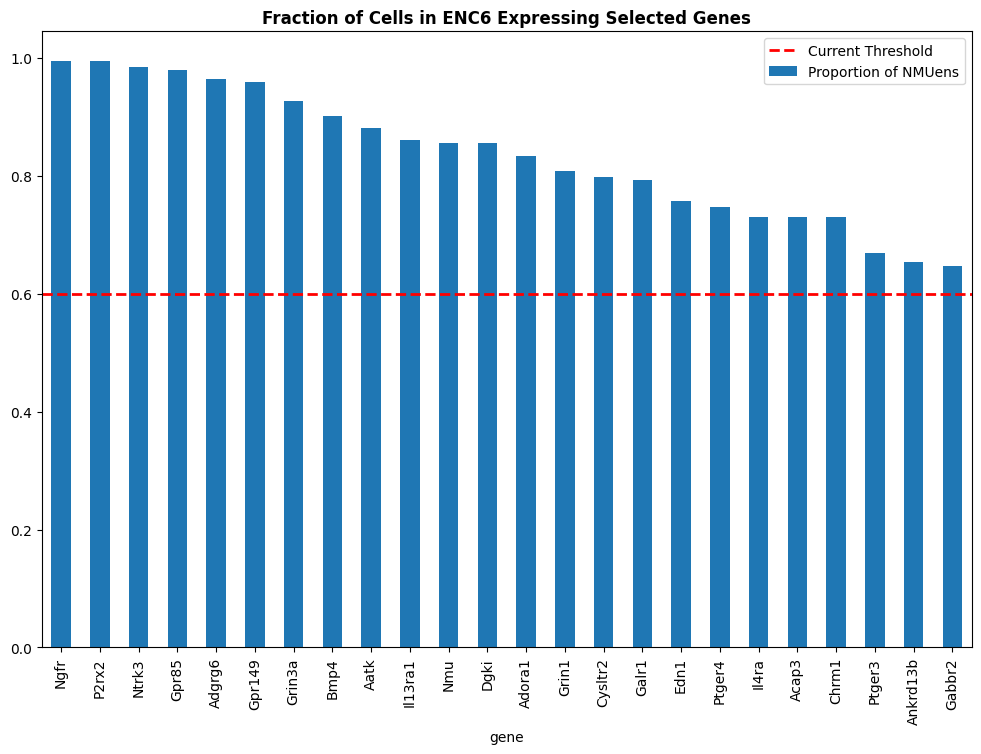

In [106]:
proportions_df.plot(kind='bar', x='gene', y='proportion_NMUens', figsize=(12, 8), label='Proportion of NMUens')
plt.title('Fraction of Cells in ENC6 Expressing Selected Genes', fontweight='bold')
plt.axhline(y=0.6, color='red', linestyle='--', linewidth=2, label='Current Threshold')
plt.legend()
plt.show()

In [102]:
NMUens_obs = NMUens_obs.drop(columns=['celltype'])
mean_df = NMUens_obs.mean()
mean_df

gene
Bmp4        1.052853
Edn1        1.098309
Nmu         2.056751
Ankrd13b    0.587411
Acap3       0.687817
Dgki        0.912556
Ntrk3       2.431499
Aatk        1.152228
Grin3a      1.567921
Grin1       0.981695
Gpr149      1.737309
Gpr85       2.080337
Chrm1       0.782504
Adora1      1.138553
Adgrg6      2.900169
Gabbr2      0.612840
Cysltr2     0.865058
Galr1       1.476607
Ngfr        2.200086
Il13ra1     0.926795
Il4ra       0.688442
Ptger3      0.639910
Ptger4      0.828927
P2rx2       2.430802
dtype: float32

In [103]:
mean_df = pd.DataFrame(mean_df)
mean_df = mean_df.rename(columns={0:'mean_expression'})
mean_df = mean_df.reset_index()
mean_df = mean_df.sort_values(by='mean_expression', ascending=False)
mean_df

,gene,mean_expression
14,Adgrg6,2.900169
6,Ntrk3,2.431499
23,P2rx2,2.430802
18,Ngfr,2.200086
11,Gpr85,2.080337
2,Nmu,2.056751
10,Gpr149,1.737309
8,Grin3a,1.567921
17,Galr1,1.476607
7,Aatk,1.152228


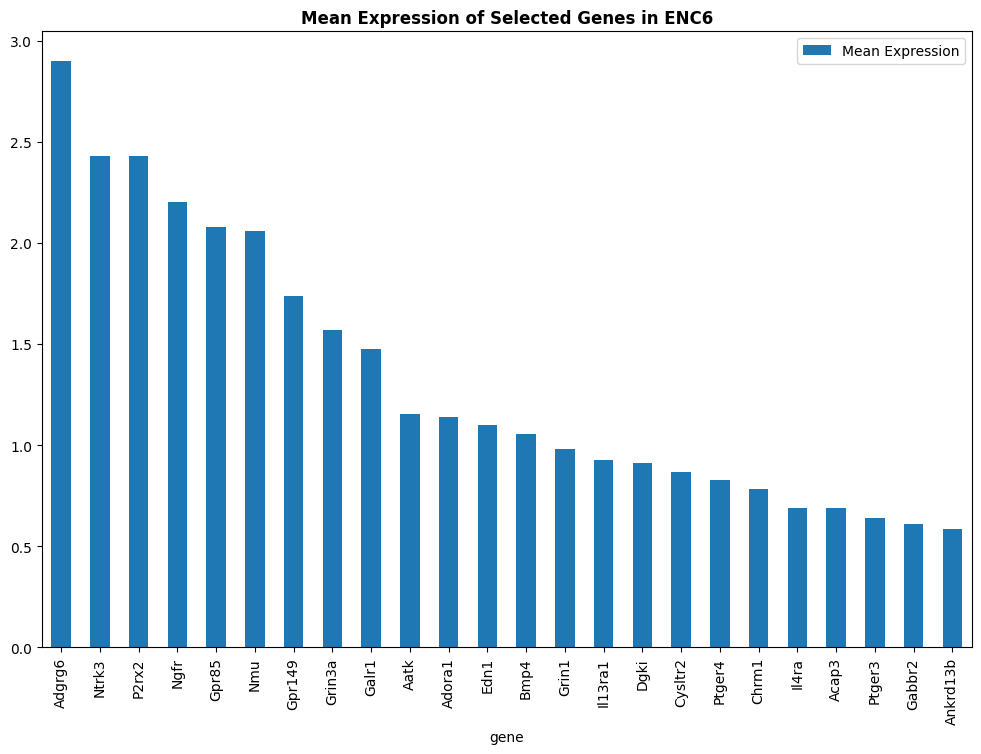

In [104]:
mean_df.plot(kind='bar', x='gene', y='mean_expression', figsize=(12, 8), label='Mean Expression')
plt.title('Mean Expression of Selected Genes in ENC6', fontweight='bold')
# plt.axhline(y=1.5, color='red', linestyle='--', linewidth=2, label='Current Threshold')
plt.legend()
plt.show()